In [18]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

seed = 0


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, font_size=10, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    plt.rcParams.update({'font.size': font_size})
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [19]:
infile = open("tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)

### Read in a dataset file

In [20]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [21]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        if data_field in ["client_pkt_cnt", "client_rst_cnt", "client_ack_cnt", "client_pkt_data", "client_pkt_retx",
                         "client_syn_cnt", "client_fin_cnt", "client_pkt_retx"]:
            val /= c_pkt_cnt
        elif data_field in ["client_bytes_uniq", "client_bytes_cnt", "client_bytes_retx"]:
            val /= c_bytes_cnt
        elif data_field in ["serv_pkt_cnt", "serv_rst_cnt", "serv_ack_cnt", "serv_ack_pck_cnt", "serv_pkts_data", 
                            "serv_pkts_retx", "serv_syn_cnt", "serv_fin_cnt"]:
            val /= s_pkt_cnt
        elif data_field in ["serv_bytes_uniq", "serv_btyes_cnt", "serv_pkts_retx"]:
            val /= s_bytes_cnt
        row.append(val)    
    return row

### Clean data row
Not implemented

In [22]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

### Get dataset
Loads all files from a directory

In [23]:
def get_dataset(path):
    print(path)
    out_data = []
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = read_in_file(temp_path)
            #print len(temp_data), len(out_data)
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    return out_data

### Load HPC datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [24]:


normal = get_dataset("./hpc/normal")
corr_01 = get_dataset("./hpc/corrupt_0.1perc")
corr_05 = get_dataset("./hpc/corrupt_0.5perc")
corr_10 = get_dataset("./hpc/corrupt_1.0perc")
delay_1_1 = get_dataset("./hpc/delay_1_var_1")
delay_5_2 = get_dataset("./hpc/delay_5_var_2")
delay_10_5 = get_dataset("./hpc/delay_10_var_5")
delay_25_20 = get_dataset("./hpc/delay_25_var_20")
drop_01 = get_dataset("./hpc/drop_01_perc")
drop_001 = get_dataset("./hpc/drop_001_perc")
drop_0005 = get_dataset("./hpc/drop_0005_perc")
dup_1 = get_dataset("./hpc/dup-1-p")
dup_2 = get_dataset("./hpc/dup_2perc")

hpc_normal = np.nan_to_num(normal)
hpc_corr_01 = np.nan_to_num(corr_01)
hpc_corr_05 =  np.nan_to_num(corr_05)
hpc_corr_10 = np.nan_to_num(corr_10)
hpc_delay_1_1 = np.nan_to_num(delay_1_1)
hpc_delay_5_2 = np.nan_to_num(delay_5_2)
hpc_delay_10_5 = np.nan_to_num(delay_10_5)
hpc_delay_25_20 = np.nan_to_num(delay_25_20)
hpc_drop_01 = np.nan_to_num(drop_01)
hpc_drop_001 = np.nan_to_num(drop_001)
hpc_drop_0005 = np.nan_to_num(drop_0005)
hpc_dup_1 = np.nan_to_num(dup_1)
hpc_dup_2 = np.nan_to_num(dup_2)



./hpc/normal


/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


./hpc/corrupt_0.1perc
./hpc/corrupt_0.5perc
./hpc/corrupt_1.0perc
./hpc/delay_1_var_1
./hpc/delay_5_var_2
./hpc/delay_10_var_5
./hpc/delay_25_var_20
./hpc/drop_01_perc
./hpc/drop_001_perc
./hpc/drop_0005_perc
./hpc/dup-1-p
./hpc/dup_2perc


In [25]:
normal = get_dataset("./dtn/FINAL_DATA/normal")
normal_2 = get_dataset("./dtn/DTN_LONG_DATA/normal")
corr_01 = get_dataset("./dtn/FINAL_DATA/corrupt_0.1perc")
corr_05 = get_dataset("./dtn/FINAL_DATA/corrupt_0.5perc")
corr_10 = get_dataset("./dtn/FINAL_DATA/corrupt_1.0perc")
delay_1_1 = get_dataset("./dtn/FINAL_DATA/delay_1_var_1")
delay_5_2 = get_dataset("./dtn/FINAL_DATA/delay_5_var_2")
delay_10_5 = get_dataset("./dtn/FINAL_DATA/delay_10_var_5")
delay_25_20 = get_dataset("./dtn/FINAL_DATA/delay_25_var_20")
drop_01 = get_dataset("./dtn/FINAL_DATA/drop_01_perc")
drop_01_2 = get_dataset("./dtn/DTN_LONG_DATA/one_perc")
drop_001 = get_dataset("./dtn/FINAL_DATA/drop_001_perc")
drop_001_2 = get_dataset("./dtn/DTN_LONG_DATA/tenth_perc")
drop_0005 = get_dataset("./dtn/FINAL_DATA/drop_0005_perc")
drop_0005_2 = get_dataset("./dtn/DTN_LONG_DATA/half_perc")
dup_01 = get_dataset("./dtn/FINAL_DATA/dup_0.1perc")
dup_1 = get_dataset("./dtn/FINAL_DATA/dup_1perc")
dup_2 = get_dataset("./dtn/FINAL_DATA/dup_2perc")

dtn_normal = np.nan_to_num(normal)
dtn_normal2 = np.nan_to_num(normal_2)
dtn_corr_01 = np.nan_to_num(corr_01)
dtn_corr_05 =  np.nan_to_num(corr_05)
dtn_corr_10 = np.nan_to_num(corr_10)
dtn_delay_1_1 = np.nan_to_num(delay_1_1)
dtn_delay_5_2 = np.nan_to_num(delay_5_2)
dtn_delay_10_5 = np.nan_to_num(delay_10_5)
dtn_delay_25_20 = np.nan_to_num(delay_25_20)
dtn_drop_01 = np.nan_to_num(drop_01)
dtn_drop_01_2 = np.nan_to_num(drop_01_2)
dtn_drop_001 = np.nan_to_num(drop_001)
dtn_drop_001_2 = np.nan_to_num(drop_001_2)
dtn_drop_0005 = np.nan_to_num(drop_0005)
dtn_drop_0005_2 = np.nan_to_num(drop_0005_2)
dtn_dup_01 = np.nan_to_num(dup_01)
dtn_dup_1 = np.nan_to_num(dup_1)
dtn_dup_2 = np.nan_to_num(dup_2)




./dtn/FINAL_DATA/normal
./dtn/DTN_LONG_DATA/normal


/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


./dtn/FINAL_DATA/corrupt_0.1perc
./dtn/FINAL_DATA/corrupt_0.5perc
./dtn/FINAL_DATA/corrupt_1.0perc
./dtn/FINAL_DATA/delay_1_var_1
./dtn/FINAL_DATA/delay_5_var_2
./dtn/FINAL_DATA/delay_10_var_5
./dtn/FINAL_DATA/delay_25_var_20
./dtn/FINAL_DATA/drop_01_perc
./dtn/DTN_LONG_DATA/one_perc
./dtn/FINAL_DATA/drop_001_perc
./dtn/DTN_LONG_DATA/tenth_perc
./dtn/FINAL_DATA/drop_0005_perc
./dtn/DTN_LONG_DATA/half_perc
./dtn/FINAL_DATA/dup_0.1perc
./dtn/FINAL_DATA/dup_1perc
./dtn/FINAL_DATA/dup_2perc


In [26]:

hpc_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           #hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_dup_1, hpc_dup_2))

hpc_data = StandardScaler().fit_transform(hpc_data)



dtn_data = np.concatenate((dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10,
                           dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           #dtn_drop_01,dtn_drop_01_2, dtn_drop_001, dtn_drop_001_2, dtn_drop_0005, dtn_drop_0005_2,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2))

dtn_data = StandardScaler().fit_transform(dtn_data)


dtn_normal = np.nan_to_num(normal)
dtn_normal2 = np.nan_to_num(normal_2)
dtn_corr_01 = np.nan_to_num(corr_01)
dtn_corr_05 =  np.nan_to_num(corr_05)
dtn_corr_10 = np.nan_to_num(corr_10)
dtn_delay_1_1 = np.nan_to_num(delay_1_1)
dtn_delay_5_2 = np.nan_to_num(delay_5_2)
dtn_delay_10_5 = np.nan_to_num(delay_10_5)
dtn_delay_25_20 = np.nan_to_num(delay_25_20)
dtn_drop_01 = np.nan_to_num(drop_01)
dtn_drop_01_2 = np.nan_to_num(drop_01_2)
dtn_drop_001 = np.nan_to_num(drop_001)
dtn_drop_001_2 = np.nan_to_num(drop_001_2)
dtn_drop_0005 = np.nan_to_num(drop_0005)
dtn_drop_0005_2 = np.nan_to_num(drop_0005_2)
dtn_dup_01 = np.nan_to_num(dup_01)
dtn_dup_1 = np.nan_to_num(dup_1)
dtn_dup_2 = np.nan_to_num(dup_2)




In [27]:
a_labels  = np.ones(len(hpc_normal  ))    *1
b_labels  = np.ones(len(hpc_corr_01  ))   *2
c_labels  = np.ones(len(hpc_corr_05  ))   *2
d_labels  = np.ones(len(hpc_corr_10  ))   *2
e_labels  = np.ones(len(hpc_delay_1_1))   *3
f_labels  = np.ones(len(hpc_delay_5_2))   *3
g_labels  = np.ones(len(hpc_delay_10_5))  *3
h_labels  = np.ones(len(hpc_delay_25_20)) *3
#i_labels  = np.ones(len(hpc_drop_01))     *4
#j_labels  = np.ones(len(hpc_drop_001))    *4
#k_labels  = np.ones(len(hpc_drop_0005))   *4
m_labels  = np.ones(len(hpc_dup_1))       *5
n_labels  = np.ones(len(hpc_dup_2))       *5

hpc_anom_type_data_labels = np.concatenate((a_labels, b_labels, c_labels, d_labels, e_labels, 
                                            f_labels, g_labels, h_labels, 
                                            #i_labels, j_labels, k_labels, 
                                            m_labels, n_labels))


In [28]:
o_labels  = np.ones(len(dtn_normal  ) + len(dtn_normal2))    *1
p_labels  = np.ones(len(dtn_corr_01  ))   *2
q_labels  = np.ones(len(dtn_corr_05  ))   *2
r_labels  = np.ones(len(dtn_corr_10  ))   *2
s_labels  = np.ones(len(dtn_delay_1_1))   *3
t_labels  = np.ones(len(dtn_delay_5_2))   *3
u_labels  = np.ones(len(dtn_delay_10_5))  *3
v_labels  = np.ones(len(dtn_delay_25_20)) *3
#w_labels  = np.ones(len(dtn_drop_01 ) + len(dtn_drop_01_2))     *4
#x_labels  = np.ones(len(dtn_drop_001) + len(dtn_drop_001_2))    *4
#y_labels  = np.ones(len(dtn_drop_0005) + len(dtn_drop_0005_2))   *4
z_labels  = np.ones(len(dtn_dup_01))      *5
aa_labels  = np.ones(len(dtn_dup_1))       *5
bb_labels  = np.ones(len(dtn_dup_2))       *5

dtn_anom_type_data_labels = np.concatenate((o_labels, p_labels, q_labels, r_labels, s_labels, 
                                            t_labels, u_labels, v_labels, 
                                            #w_labels, x_labels,y_labels,
                                            z_labels, 
                                            aa_labels, bb_labels))

all_anom_type_data_labels = 

In [29]:
#dtn_anom_type_data_labels.shape
dtn_data.shape

(2968, 89)

### DTN Standalone

In [30]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(dtn_data, 
                                                                    dtn_anom_type_data_labels, test_size=0.45, random_state=3)

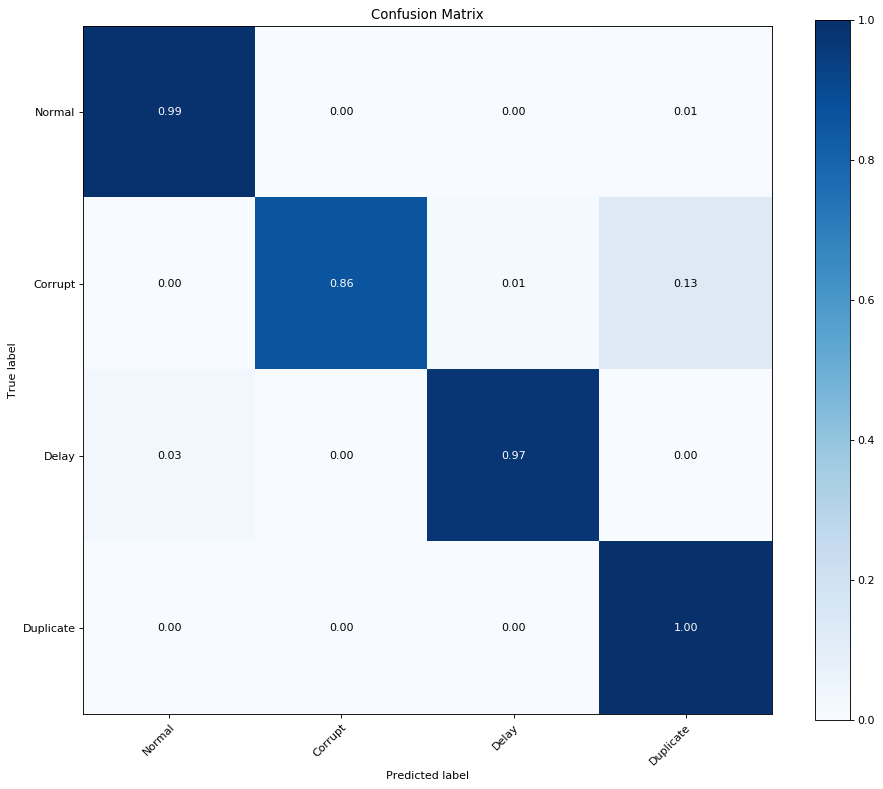

Total Error Count :  21
Normal Class Error Rate :  0.8233532934131738 %
Total Error Rate :  1.5718562874251496 %
Total Errors 21
False Positives  1.4221556886227544 %
False Negatives  0.14970059880239522 %


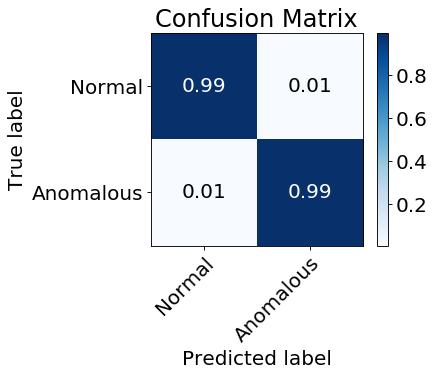

In [31]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

### HPC Data on DTN trained SVM

In [32]:
from sklearn.model_selection import train_test_split

hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, test_size=0.45, random_state=3)

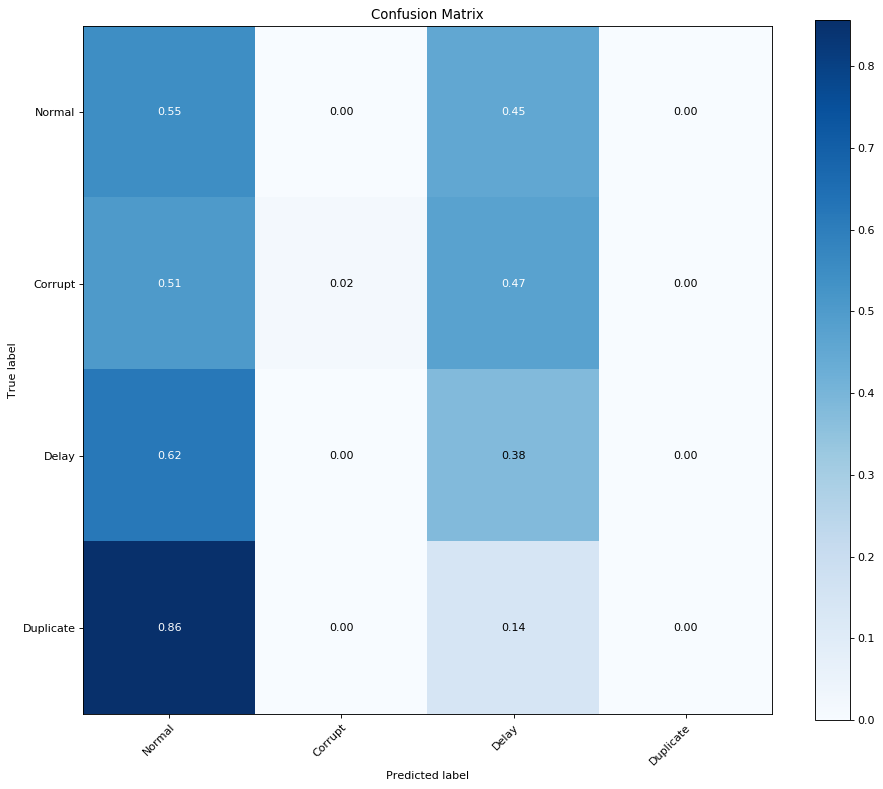

Total Error Count :  20922
Normal Class Error Rate :  68.07826750773434 %
Total Error Rate :  84.06123186950059 %
Total Errors 20922
False Positives  18.799469645224796 %
False Negatives  65.26176222427578 %


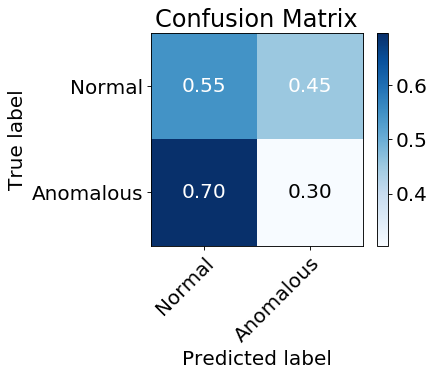

In [33]:
predicted_labels = clf.predict(hpc_test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Duplicate"]

plot_confusion_matrix(hpc_test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != hpc_test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or hpc_test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != hpc_test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if hpc_test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [34]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(dtn_data, 
                                                                    dtn_anom_type_data_labels, test_size=0.45, random_state=3)

predicted_labels = clf.predict(hpc_test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Duplicate"]

plot_confusion_matrix(hpc_test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != hpc_test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or hpc_test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != hpc_test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if hpc_test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

### DTN Data on HPC trained SVM

In [37]:
from sklearn.model_selection import train_test_split

hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, test_size=0.45, random_state=3)

In [38]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(hpc_train_data, hpc_train_labels)
predicted_labels = clf.predict(test_data)


In [ ]:
predicted_labels = clf.predict(hpc_test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Duplicate"]

plot_confusion_matrix(hpc_test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != hpc_test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or hpc_test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != hpc_test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if hpc_test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()


### Merge Data

In [ ]:
from sklearn.model_selection import train_test_split

hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, test_size=0.45, random_state=3)